In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from __future__ import print_function

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
sigma = 0.02
class MineNet(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=sigma)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=sigma)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=sigma)
        nn.init.constant_(self.fc3.bias, 0)
        nn.init.normal_(self.fc4.weight,std=sigma)
        nn.init.constant_(self.fc4.bias, 0)
        nn.init.normal_(self.fc5.weight,std=sigma)
        nn.init.constant_(self.fc5.bias, 0)
        
    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = F.elu(self.fc3(output))
        output = F.elu(self.fc4(output))
        output = self.fc5(output)
        return output

In [5]:
mine_net = MineNet(input_size=2)
mine_net.to(device)

MineNet(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=100, bias=True)
  (fc5): Linear(in_features=100, out_features=1, bias=True)
)

In [6]:
def phi_grad_at(x,y):
    phi = mine_net(torch.FloatTensor(np.array([[x,y]])).to(device))
    mine_net.zero_grad() 
    phi.backward()
    return [param.grad.clone() for param in mine_net.parameters()]

In [7]:
def dot(v1,v2):
    s = 0
    for i in range(len(v1)):
        s=s+(v1[i] * v2[i]).sum()
    return s

In [18]:
phi_grad_1 = phi_grad_at(1,1)

In [19]:
dot(phi_grad_1,phi_grad_at(0,0))

tensor(1.0358, device='cuda:0')

In [20]:
Xmin = -4
Xmax = 4
Ymin = -4
Ymax = 4
Xgrids = 50
Ygrids = 50
x = np.linspace(Xmin, Xmax, Xgrids)
y = np.linspace(Ymin, Ymax, Ygrids)
xs, ys = np.meshgrid(x,y)
XY = np.array((xs,ys))
Z=np.array([dot(phi_grad_1,phi_grad_at(XY[0,i,j],XY[1,i,j])).item() 
            for j in range(ys.shape[0]) 
            for i in range(xs.shape[1])]).reshape(xs.shape[1],ys.shape[0])

Text(0, 0.5, 'y')

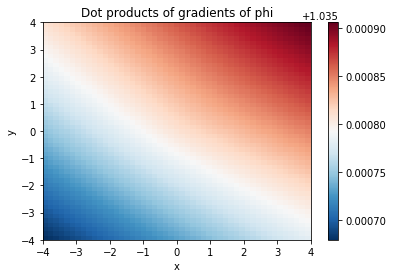

In [21]:
plt.pcolormesh(xs,ys,Z,cmap='RdBu_r')
plt.title("Dot products of gradients of phi")
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')